In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import subprocess 
import os
import pickle
import trimesh
from collections import defaultdict

from torch.utils.data import Dataset, DataLoader

import SimpleITK as sitk

import open3d as o3d

# import tqdm
import subprocess
from scipy.ndimage import gaussian_filter

from dataloaders import VIA11_Corrected_CS_Loader
import multiprocessing as mp

from spam import SPAM

from shape_utils import sulcus_dist

from sklearn.manifold import Isomap

from pathlib import Path

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Testing

In [9]:
ds = VIA11_Corrected_CS_Loader(bv_good=True, corrected=True, all_bv=False)
len(ds)
# Path(ds[0]['rmesh']).exists()

286

In [10]:
subject = ds[0]
print(subject)

lmesh = o3d.io.read_triangle_mesh(subject['lmesh'])
rmesh = o3d.io.read_triangle_mesh(subject['rmesh'])

lsegm = sitk.ReadImage(str(subject['lsegm']))
rsegm = sitk.ReadImage(str(subject['rsegm']))

{'subject_id': 'sub-via003', 'lsegm': PosixPath('/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited/DRCMR/LSulci_sub-via003_default_session_best_edit_NHT.nii.gz'), 'rsegm': '/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited/DRCMR/RSulci_sub-via003_default_session_best_edit_NHT.nii.gz', 'lmesh': '/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited/DRCMR/LSulci_sub-via003_default_session_best_edit_NHT.ply', 'rmesh': '/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited/DRCMR/RSulci_sub-via003_default_session_best_edit_NHT.ply', 'type': 'corrected', 'site': 'DRCMR'}


In [11]:
lmesh.paint_uniform_color([1, 0.706, 0])

TriangleMesh with 2186 points and 4368 triangles.

In [12]:
lmesh.compute_vertex_normals()
lmesh.compute_triangle_normals()
o3d.visualization.draw_geometries([rmesh])

1. Mirroring

The right sulci were finally mirrored relative to the interhemispheric plane in order to facilitate the comparison with the left ones. https://www.sciencedirect.com/science/article/pii/S1053811921011083#sec0037

In [13]:
rsegm_flipped =  sitk.Flip(rsegm, [False, False, True])

2. ICP Registstration

The dissimilarity between any two given sulci was then computed in the following way: sulcus A was registered to sulcus B using a rigid transformation, using the Iterative Closest Point algorithm (ICP) (Besl and McKay, 1992), and the residual distance dA→B between the two sulci after registration was captured using the Wasserstein distance (Dobrushin, 1970). 

https://www.sciencedirect.com/science/article/pii/S1053811921011083#sec0037

In [14]:
lsegm_points = np.stack(np.where(sitk.GetArrayFromImage(lsegm))).T
rsegm_points = np.stack(np.where(sitk.GetArrayFromImage(rsegm_flipped))).T

In [15]:
#Apply the iterative closest point algorithm to align a point cloud with another point cloud or mesh.
# Will only produce reasonable results if the initial transformation is roughly correct.
# Initial transformation can be found by applying Procrustes’ analysis to a suitable set of
# landmark points (often picked manually).

# finds the transformation matrix sending a to b
matrix, transformed, cost = trimesh.registration.icp(a=rsegm_points, b=lsegm_points, max_iterations=1000)

In [16]:
orig_img = sitk.ReadImage('/mnt/projects/VIA_Vlad/nobackup/BrainVisa/BrainVisa/DRCMR/sub-via003/t1mri/default_acquisition/sub-via003.nii.gz')

#### Visualize ICP Registration

In [ ]:
right_segm_registered = np.zeros_like(sitk.GetArrayFromImage(rsegm_flipped))
right_segm_registered[tuple(np.round(transformed).astype(int).T)] = 1
right_segm_registered_img = sitk.GetImageFromArray(right_segm_registered)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(sitk.GetArrayFromImage(orig_img)[:, 180, :], cmap='gray')
axs[0, 0].set_title('Original image')
axs[0, 0].set_axis_off()

axs[0, 1].imshow(sitk.GetArrayFromImage(lsegm)[:, 180, :], alpha=0.5)
axs[0, 1].imshow(sitk.GetArrayFromImage(rsegm)[:, 180, :], alpha=0.5)
axs[0, 1].set_title('Original segmentations')
axs[0, 1].set_axis_off()

axs[1, 0].imshow(sitk.GetArrayFromImage(lsegm)[:, 180, :], alpha=0.5)
axs[1, 0].imshow(sitk.GetArrayFromImage(rsegm_flipped)[:, 180, :], alpha=0.5)
axs[1, 0].set_title('Right flipped to left')
axs[1, 0].set_axis_off()

axs[1, 1].imshow(sitk.GetArrayFromImage(lsegm)[:, 180, :], alpha=0.5)
axs[1, 1].imshow(right_segm_registered[:, 180, :], alpha=0.5)
axs[1, 1].set_title('Right flipped and registered to left')
axs[1, 1].set_axis_off()

plt.tight_layout()

plt.show()


# sitk.WriteImage(rsegm, './rsegm.nii.gz')
# sitk.WriteImage(rsegm_flipped, './rsegm_flipped.nii.gz')
# sitk.WriteImage(lsegm, './lsegm.nii.gz')
# sitk.WriteImage(right_segm_registered_img, './right_segm_registered_img.nii.gz')

#### Calculate Wasserstein Distance

# Calculate Distance Matrix

In [2]:
cs_ds = VIA11_Corrected_CS_Loader(bv_good=True, corrected=True, all_bv=False, preload=True)

# unravell all the sulci
sulci_list = cs_ds.get_subjects()


100%|██████████| 286/286 [00:46<00:00,  6.18it/s]


Compute using draft below or load from files

In [3]:
# # compute distance matrix
# sulci_distance_matrix = []
# sulci_reg_keys = []
    
# for s in tqdm(sulci_list):
#     dists, reg_keys = sulcus_dist(s, sulclist=sulci_list)
#     sulci_distance_matrix.append(dists)
#     sulci_reg_keys.append(reg_keys)

# sulci_distance_matrix = np.array(sulci_distance_matrix)
# sulci_reg_keys = np.array(sulci_reg_keys)

# np.save('./sulci_distance_matrix.npy', sulci_distance_matrix)
# np.save('./sulci_reg_keys.npy', sulci_reg_keys)

In [4]:
sulci_distance_matrix = np.load('.././sulci_distance_matrix.npy')
sulci_reg_keys = np.load('.././sulci_reg_keys.npy')
np.shape(sulci_distance_matrix)

(572, 572)

In [5]:
sulci_distance_matrix

array([[0.        , 0.71139947, 0.73843293, ..., 0.1801372 , 0.21324687,
        0.80583539],
       [0.70339746, 0.        , 0.56630353, ..., 1.1333045 , 0.58440032,
        0.47385245],
       [0.73843293, 0.56636564, 0.        , ..., 0.76675295, 0.56602392,
        1.17124342],
       ...,
       [0.18022408, 1.1333045 , 0.76502976, ..., 0.        , 1.52604137,
        1.16903509],
       [0.21324687, 0.5840742 , 0.56602392, ..., 1.52639516, 0.        ,
        0.90408223],
       [0.81124244, 0.47385245, 1.17124342, ..., 1.16903509, 0.90408269,
        0.        ]])

# Calculate ISOMAP Features

In order to visualize the organization of the Isomap axis, all the sulci are first aligned to a template sulcus in order to obtain similar orientations across the whole set. This is performed for each sulcus using the optimal transformation yielded by the ICP algorithm. The template used to align all the sulci is the sulcus that minimizes the average distance to the rest of the whole set. Therefore, by definition the template has the most neutral shape and hence yields the best alignment across the set. Then each sulcus is translated along the antero-posterior brain axis proportionally to its Isomap coordinate (see Fig. 2).

In [6]:
spam = SPAM(sulci_list, sulci_distance_matrix)

Average sulcus automatically selected is right_sub-via017.
Registering sulci to average sulcus


100%|██████████| 572/572 [03:12<00:00,  2.98it/s]


In [7]:
all_spam_sulci, isomap_feat_values = spam.retrieve_isomap_spams(sample_shapes_n=30,
                                        isomap_components=10,
                                        n_neighbors=10)

 50%|█████     | 5/10 [02:37<02:59, 35.89s/it]

In [ ]:
# do the smooting and binarization after SPAM

In [11]:
sigma = 1
bin_thresh = 0.3
save_path = Path('./meshes/test/').absolute()

def save_mesh(segm_array:np.ndarray,
              sigma:float, bin_thresh:np.float32,
              label:str, save_path:Path,
              template_img:sitk.Image=None,):
    # smooth the segmentation
    segm_array = gaussian_filter(segm_array, sigma=sigma)
    
    # binarize the segmentation
    segm_array = (segm_array >= bin_thresh).astype(np.int16)
    
    segm_img = sitk.GetImageFromArray(segm_array)
    if template_img is not None:
        segm_img.CopyInformation(template_img)
    
    # save the segmentation
    sitk.WriteImage(segm_img, save_path/f'{label}.nii.gz')
    
    # transform it into a mesh
    cmd = ['/mrhome/vladyslavz/portable_apps/brainvisa4_5/bin/AimsMeshBrain', '-i', save_path/f'{label}.nii.gz', '-o', save_path/f'{label}.ply']
    subprocess.run(cmd, shell=False, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
    os.remove(save_path/f'{label}.nii.gz')
    os.remove(save_path/f'{label}.ply.minf')

In [12]:
orig_img = sitk.ReadImage('/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited/CFIN/LSulci_sub-via010_default_session_best_edit_NHT.nii.gz')

In [15]:
for i, s in tqdm(enumerate(all_spam_sulci[0]), total=len(all_spam_sulci[0])):
    save_mesh(s, sigma=0.8,
              bin_thresh=0.2,
              label=f'test{i}', save_path=save_path, template_img=orig_img)

100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


In [ ]:
isomap_components = 10
n_neighbors = 10

iso = Isomap(n_components=isomap_components, n_jobs=24, n_neighbors=n_neighbors, radius=None)
sdm_trasformed = iso.fit_transform(sulci_distance_matrix)

In [ ]:
print('Sulci index and value that minimized average distance to other sulci', np.argmin(sulci_distance_matrix.mean(axis=1)), np.min(sulci_distance_matrix.mean(axis=1)))
print('Sulci index and value that maximized average distance to other sulci', np.argmax(sulci_distance_matrix.mean(axis=1)), np.max(sulci_distance_matrix.mean(axis=1)))

Sulci index and value that minimized average distance to other sulci 155 0.3877558596690697
Sulci index and value that maximized average distance to other sulci 184 1.0465513545806178


In [ ]:
sdm_trasformed.shape

(572, 10)

In [ ]:
sulci_row_names = [x.replace('-left_sub-via003', '') for x in sulci_reg_keys[:, 0]]

In [ ]:
# # plot histogram of all features in sdm_trasformed
# fig, axs = plt.subplots(2, 5, figsize=(20, 10))
# axs = axs.ravel()
# for i in range(sdm_trasformed.shape[1]):
#     axs[i].hist(sdm_trasformed[:, i], bins=100)
#     axs[i].set_title(f'Feature {i}')
# plt.tight_layout()
# plt.show()

Computing local average shapes using weighted SPAM: in order to clarify the link between the Isomap axis and the sulcal shape, local averages can be computed at different positions. Each local average results from a weighted Statistical Parametric Anatomical Map, namely a SPAM where the contribution of each sulcus is weighted according to its distance to the average location. All sulci are aligned to a template neutral sulcus before the computation of a weighted sum of 3D volumes. The resulting volume is smoothed by convolution with a 3D Gaussian. Finally, a simple threshold is used to provide a 3D representation of one of the weighted SPAM iso-surfaces.

In [ ]:
spam = SPAM(sulci_list=sulci_list, average_sulci=sulci_list[155])

Registering sulci to average sulcus


100%|██████████| 572/572 [03:04<00:00,  3.10it/s]


In [ ]:
sample_shapes_n = 10



[-15 -11  -7  -3   0   4   8  12  16  20] 
 -15.70394633053466 20.71454179948824


In [ ]:
spam_test = spam.get_spam(dist)

572it [00:25, 22.06it/s]


In [ ]:
i = sitk.ReadImage('/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited/CFIN/LSulci_sub-via010_default_session_best_edit_NHT.nii.gz')

In [ ]:
a = 
a.CopyInformation(i)
a = a + sitk.Cast(i, sitk.sitkFloat64)*0.2

In [ ]:
sitk.Image(i)

192

In [15]:
i = sitk.ReadImage('/mnt/projects/VIA_Vlad/nobackup/BrainVisa/CS_edited/CFIN/LSulci_sub-via010_default_session_best_edit_NHT.nii.gz')

In [31]:
spam_test_img = sitk.GetImageFromArray(1*(spam_sulci[0][48]>bin_threshold).astype(np.int16))
spam_test_img.CopyInformation(i)
sitk.WriteImage(spam_test_img, './spam_test_img.nii.gz')
subprocess.run(cmd)
spam_test_mesh = o3d.io.read_triangle_mesh('/mrhome/vladyslavz/git/central-sulcus-analysis/shape_features/spam_test_mesh.ply')
o3d.visualization.draw_geometries([spam_test_mesh])

reading image      : done
resolutions        : (0.899994 mm,0.902778 mm,0.902771 mm)
reading slice      :                      1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91010101010101010101011111111111111111111121212121212121212121313131313131313131314141414141414141414151515151515151515151616161616161616161617171717171717171717181818181818181818181919191919191919191920202020202020202020212121212121212121212222222222222222222223232323232323232323242424242424242424242525252525252525252526262626262626262626272727272727272727272828282828282828288
getting interface  :         done 
processing mesh    : reduced neighborhoodextended neighborhoovertices            smoothing  iteration                                            1   1   1   1   1   1   1   1   1   1   2   2   2   2   2   2   2   2   2   2   3                       pass 1/3 : decimating     

The weight of this contribution follows an exponential decay relative to the square of the distance to the location. Hence, each average image provides a good representation of the shape of the sulci around the corresponding location in the axis.

All sulci are aligned to a template neutral sulcus before the computation of a weighted sum of 3D volumes. The resulting volume is smoothed by convolution with a 3D Gaussian. Finally, a simple threshold is used to provide a 3D representation of one of the weighted SPAM iso-surfaces.



In [ ]:
dist.min()

0.040119135127172474

In [ ]:
np.sum(dist<100)

118

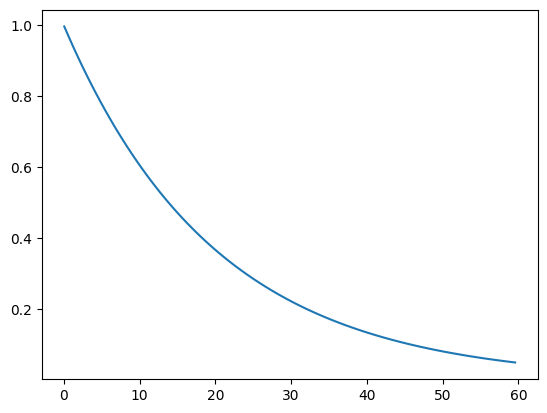

In [21]:
x = np.linspace(dists_topprcn.min(), dists_topprcn.max(), 100)
y = [np.exp(-i/20) for i in x]

plt.plot(x, y)

In [ ]:

spam_test_smooth = gaussian_filter(spam_test, sigma=1)

In [ ]:
spam_test_smooth.max()

0.3292106211282197

In [ ]:
spam_test.max()

0.39809402505378033

### TODO:

1. Finish the pieces of pipeline
    * ~~exponential decay of the distance to the location to get the weighted SPAM and use all sulci to get the average image~~
    * ~~gaussian smoothing of the resulting volume~~
    * ~~thresholding to get the 3D representation of the weighted SPAM iso-surfaces~~
    * ~~automatic mesh creation from the 3D representation from code calling brainvisa~~
    * visualization of the 3D representation of the weighted SPAM iso-surfaces with open3d
2. Create a pipeline to run the whole pipeline
    * selection of all hyperparameters to be tuned
    * refactor code and move into modules
3. Perform hyperparameter tuning
    * for the registration / ISOMAP following paper's guidance
4. Generate automatic reports and graphs for the ISOMAP features (visualization of the 3D representation of the weighted SPAM iso-surfaces)
5. Perform frequency analysis of the ISOMAP features following paper's guidance


reading image      : done
resolutions        : (0.899994 mm,0.902778 mm,0.902771 mm)
reading slice      :                      1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91010101010101010101011111111111111111111121212121212121212121313131313131313131314141414141414141414151515151515151515151616161616161616161617171717171717171717181818181818181818181919191919191919191920202020202020202020212121212121212121212222222222222222222223232323232323232323242424242424242424242525252525252525252526262626262626262626272727272727272727272828282828282828288
getting interface  :         done 
processing mesh    : reduced neighborhoodextended neighborhoovertices            smoothing  iteration                                            1   1   1   1   1   1   1   1   1   1   2   2   2   2   2   2   2   2   2   2   3                       pass 1/3 : decimating      

CompletedProcess(args=['/mrhome/vladyslavz/portable_apps/brainvisa4_5/bin/AimsMeshBrain', '-i', '/mrhome/vladyslavz/git/central-sulcus-analysis/shape_features/spam_test_img.nii.gz', '-o', '/mrhome/vladyslavz/git/central-sulcus-analysis/shape_features/spam_test_mesh.ply'], returncode=0)